## Modelo de regresión logística para identificar posibles clientes

### 1. Carga de paquetes y data

In [1]:
#Librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile as zf

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE

%matplotlib inline

In [2]:
#Cargar el .zip
datazip=zf.ZipFile('Bank_Campaign.csv.zip')
#Archivos en el .zip
datazip.namelist()
#Lectura de los datos
data=pd.read_csv(datazip.open('Bank_Campaign.csv'),';')

C:\Users\willi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3397: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  exec(code_obj, self.user_global_ns, self.user_ns)


## 2. Exploración de los datos

In [3]:
#Dimensiones de data
data.shape
data.head(10)
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'subscribed'],
      dtype='object')

In [4]:
#Estadisticos de variables numéricas y nominales
data.info()
data.describe()
data.describe(include='O')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,subscribed
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [5]:
#Separamos variables numéricas y categóricas
numeric=data.iloc[:,(data.dtypes!='object').values].columns
categorical=data.iloc[:,(data.dtypes=='object').values].columns

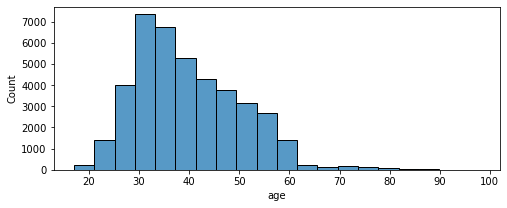

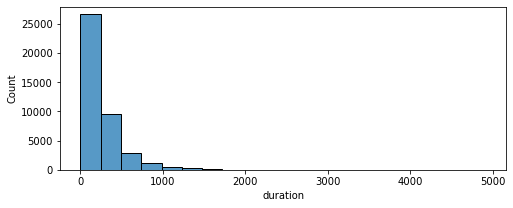

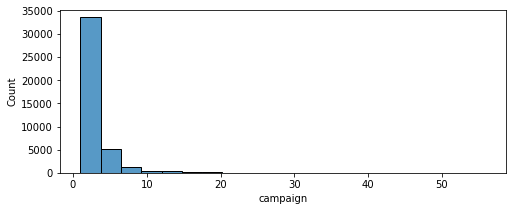

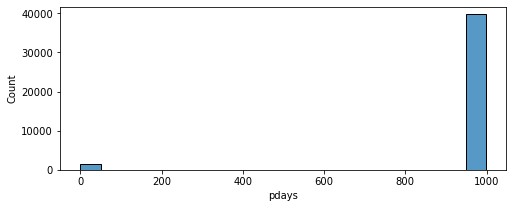

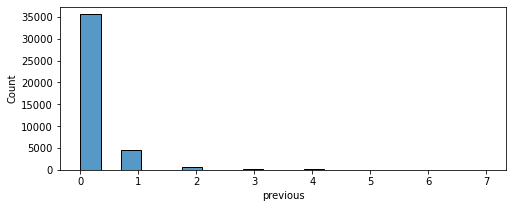

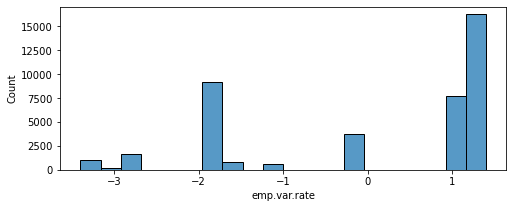

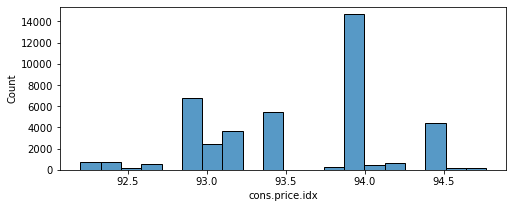

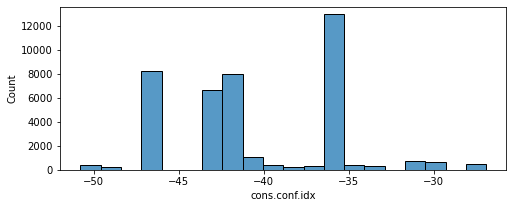

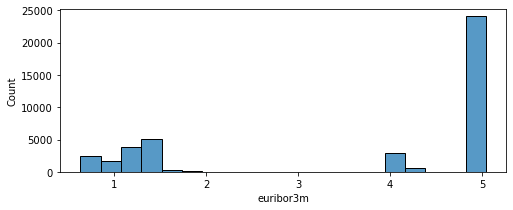

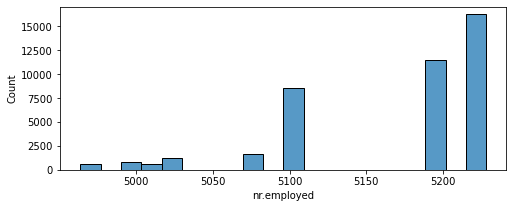

In [6]:
#Histogramas de las variables numéricas
for i in numeric:
    fig,ax=plt.subplots(figsize=(8,3))
    sns.histplot(data=data,x=i,bins=20)
    plt.show()

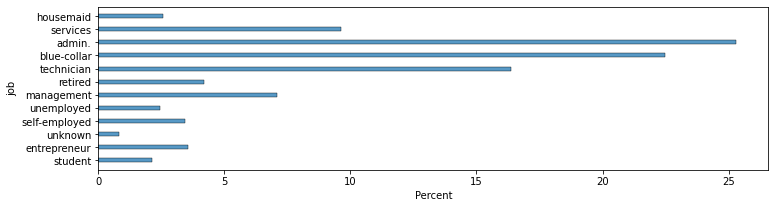

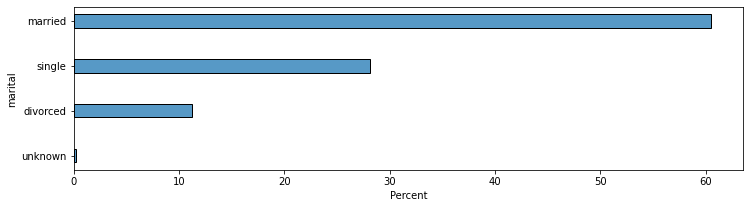

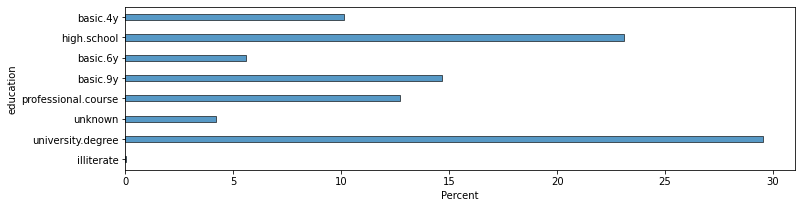

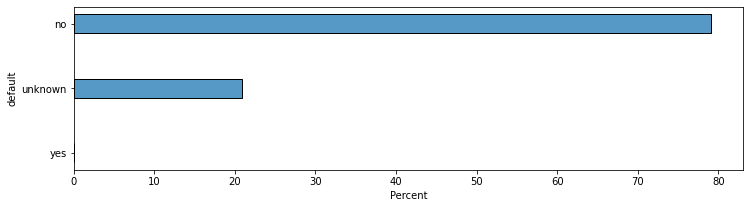

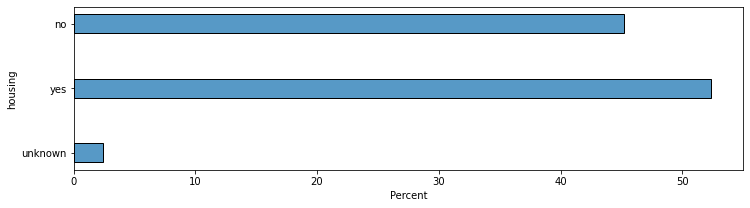

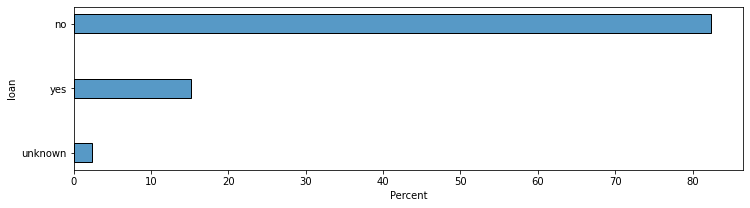

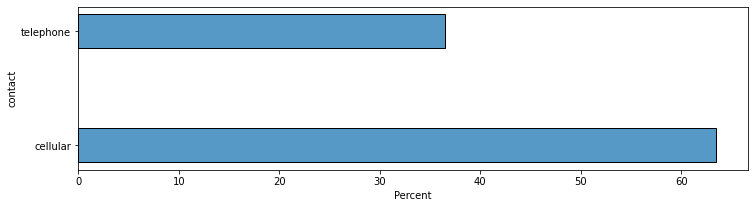

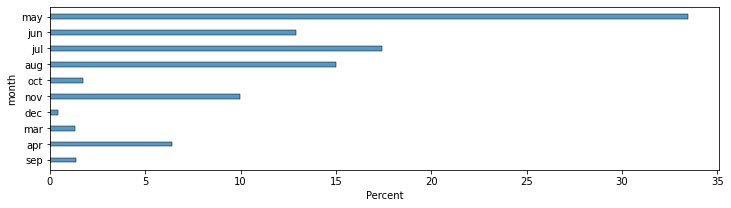

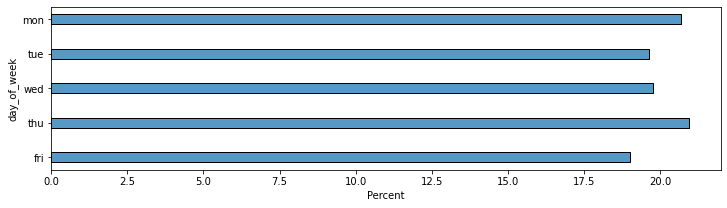

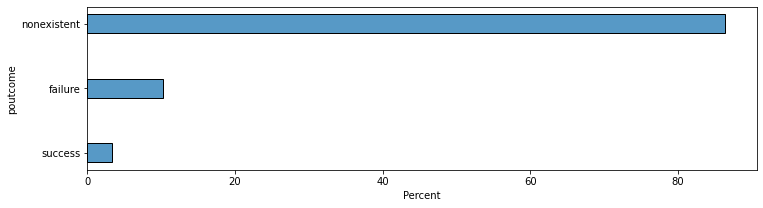

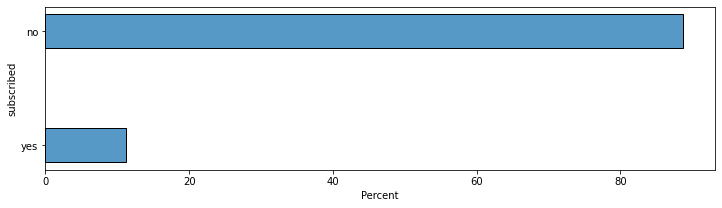

In [7]:
#Gráfico de barras de variables nominales
for i in categorical:
    fig,ax=plt.subplots(figsize=(12,3))
    sns.histplot(data=data,y=i,stat="percent",shrink=0.3)
    plt.show()

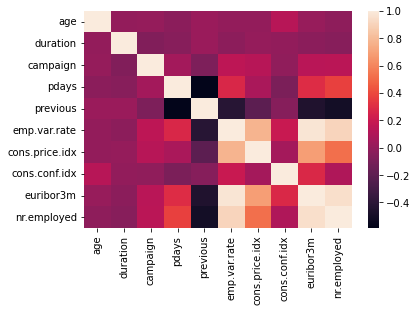

In [12]:
#Analizamos las correlaciones de las variables numéricas
sns.heatmap(data.corr())
plt.show()

### 2.1 EDA:Estudio de variable target

no     36548
yes     4640
Name: subscribed, dtype: int64

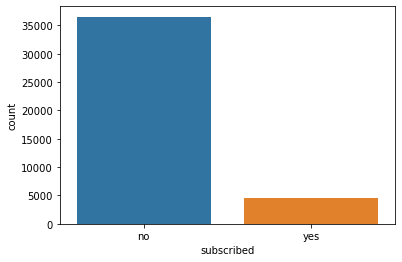

In [9]:
sns.countplot(x='subscribed',data=data)
#Número de personas que se suscribieron o no
data.subscribed.value_counts()
#La base está desbalanceada

In [10]:
#Porcentajes de personas que se suscribieron
data.subscribed.value_counts()/data.shape[0]*100

no     88.734583
yes    11.265417
Name: subscribed, dtype: float64

## 3. Procesamiento de datos

In [11]:
#Inputación de variables
data.job.replace("unknown","admin.",inplace=True)
data.marital.replace("unknown","married",inplace=True)
data.education.replace("unknown","university.degree",inplace=True)
data=data.loc[data.education!="illiterate"]
data=data.loc[data.default!="yes"]
data.housing.replace("unknown","yes",inplace=True)
data.loan.replace("unknown","no",inplace=True)

In [13]:
#Eliminamos los atributos: "duration"(que se conoce después de realizar la llamada) y "emp.var.rate"
#que tienen una correlación mayor a 0.8 con las demás variables
data.drop(["duration", "emp.var.rate"],axis=1,inplace=True)
#Quitamos duplicados
data.drop_duplicates(inplace=True)
#Verificamos si hay valores nulos
data.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
subscribed        0
dtype: int64

In [14]:
#Transformamos variable target
data.subscribed.replace(['yes','no'],[1,0],inplace=True)

In [15]:
#Transformamos variable pdays: 1: si se contactó con el cliente en una campaña previa y 0: caso contrario
data.pdays=(data.pdays!=999).astype("int")

0    37785
1     1513
Name: pdays, dtype: int64

In [16]:
#Transformamos los datos numéricos con robut scaler
transform=RobustScaler()
variables=['age','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
data[variables]=transform.fit_transform(data[variables])

In [17]:
#Convertimos variables categóricas en dummies
data=pd.get_dummies(data,drop_first=True)

## 4. Ajuste del modelo de regresión Logística

In [18]:
X_train, X_test, y_train, y_test=train_test_split(data.drop('subscribed',axis=1),data.subscribed,test_size=0.2,random_state=120)

model = LogisticRegression(C=1.0,penalty='none',random_state=1,class_weight="balanced",solver="newton-cg",max_iter=800)
model.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', max_iter=800, penalty='none',
                   random_state=1, solver='newton-cg')

## 5. Evaluación del modelo

In [20]:
#En el train
y_predict_t=model.predict(X_train)

print(classification_report(y_train,y_predict_t))
print(confusion_matrix(y_train,y_predict_t))


              precision    recall  f1-score   support

           0       0.94      0.84      0.89     27725
           1       0.35      0.63      0.45      3713

    accuracy                           0.82     31438
   macro avg       0.65      0.73      0.67     31438
weighted avg       0.87      0.82      0.84     31438

[[23326  4399]
 [ 1382  2331]]


In [22]:
#En la muestra test
y_predict=model.predict(X_test)

print(classification_report(y_test,y_predict))
print(confusion_matrix(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90      6980
           1       0.35      0.64      0.45       880

    accuracy                           0.83      7860
   macro avg       0.65      0.74      0.67      7860
weighted avg       0.88      0.83      0.85      7860

[[5931 1049]
 [ 321  559]]


## 6. Conclusiones

* Los datos estaban desbalanceados por lo que ponderamos la base.
* El modelo de regresión logística tiene una precisión de 95% y recall de 85% identificando las personas que no se suscribirían, en tanto que para los clientes que sí se suscribirían se tiene una precisión de 35% y recall de 64%.
* En general, el modelo tiene una precisión del 83%.
* Para mejorar la predicción del modelo se pueden agregar nuevas variables como el salario o lugar de residencia que pueden ayudar a mejorar la clasificación.